#### islam --> 1191375

In [72]:

id = "1191375"
dig = [int(d) for d in id]
threshold = sum(dig) / len(dig)
threshold

3.857142857142857

In [73]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def binary_label_transform(label):
    return 1 if label > threshold else 0

train_data.targets = train_data.targets.apply_(binary_label_transform)
test_data.targets = test_data.targets.apply_(binary_label_transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)


Define the CNN Model

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#  1 A B C D Y X
#  1 1 9 1 3 7 5


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 9, 3)  # X + 4 = 5 + 4 = 9
        self.conv2 = nn.Conv2d(9, 22, 3) # Y + 15 = 7 + 15 = 22
        self.pool = nn.AvgPool2d(2, 2)   # Define the pooling layer
        self.fc1 = nn.Linear(22 * 5 * 5, 191)  # ABC neurons
        self.fc2 = nn.Linear(191, 16)
        self.fc3 = nn.Linear(16, 1)

# 28 x 28 x 1
# 26 x 26 x 9
# 13 x 13 x 9
# 11 x 11 x 22
# 5 x 5 x 22


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Create an instance of the SimpleCNN class
model = SimpleCNN()

# Move the model to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)  
model.to(device) 


cuda:0


SimpleCNN(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(9, 22, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=550, out_features=191, bias=True)
  (fc2): Linear(in_features=191, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [75]:
#optemizer
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()


In [76]:
# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(9, 22, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=550, out_features=191, bias=True)
  (fc2): Linear(in_features=191, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [77]:
#Training

train_accuracies = []

for epoch in range(3):
    correct = 0
    total = 0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        predicted = (outputs > 0.5).float()
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

    epoch_accuracy = 100 * correct / total
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {epoch_accuracy}%")
    
print('Finished Training')

Epoch 1, Loss: 0.008574506267905235, Accuracy: 95.89%
Epoch 2, Loss: 0.033928677439689636, Accuracy: 98.78833333333333%
Epoch 3, Loss: 0.0008659749291837215, Accuracy: 99.16333333333333%
Finished Training


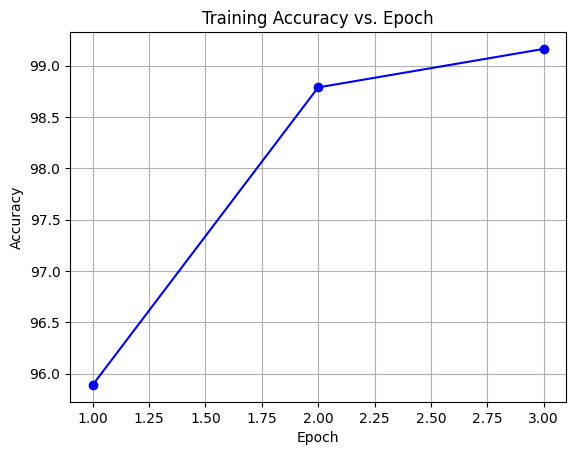

In [78]:
import matplotlib.pyplot as plt

epochs = range(1, 4)  
plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [79]:
# I calculated the test accuracy and saved the misclassified imgs, labels and preds
correct = 0
total = 0
misclassified_images = []
misclassified_labels = []
misclassified_preds = []


model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        
        misclassified_mask = (predicted != labels.unsqueeze(1)).squeeze()

        
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

        misclassified_mask = (predicted != labels.unsqueeze(1)).squeeze()

        # Ensure mask & lebels  same shape
        if misclassified_mask.ndim > 1:
            misclassified_mask = misclassified_mask.squeeze(1)

        misclassified_images.extend(images[misclassified_mask].cpu())
        misclassified_labels.extend(labels[misclassified_mask].cpu())
        misclassified_preds.extend(predicted[misclassified_mask].cpu())


# Calculate accuracy
if total > 0:
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy}%')
else:
    print("No data to evaluate.")


Accuracy of the network on the test images: 98.87%


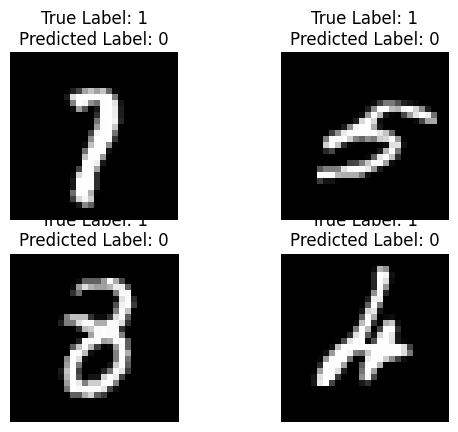

In [80]:
import matplotlib.pyplot as plt

for i, image in enumerate(misclassified_images[:4]):
    true_label = misclassified_labels[i].item()
    predicted_label = int(misclassified_preds[i].item() > 0.5)
    image = image.squeeze()
    plt.subplot(2,2,i+1)
    plt.imshow(image, cmap="gray")
    plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    plt.axis('off')
plt.show()
